# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("../..")

In [2]:
os.environ.get("CONDA_PREFIX")

'/epyc/opt/anaconda'

In [3]:
os.nice(1)

1

In [4]:
import thor

## Run THOR

In [5]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

In [6]:
#simulated_ephemeris = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.eph", sep=" ", index_col=False, low_memory=False)
simulated_ephemeris = thor.readEPHFile("../../analysis/ztf/MPCORB_20181106_ZTF.eph")
#orbits = pd.read_csv("../../analysis/ztf/known_object_observations_nid_610_624.orb", sep=" ", index_col=False, low_memory=False)
orbits = thor.readORBFile("../../analysis/ztf/MPCORB_20181106_ZTF_keplerian.orb", elementType="keplerian")

#observations = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)
observations = pd.read_csv("../../analysis/ztf/observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)

observations.sort_values(by="mjd", inplace=True)
#observations.drop(index=observations[observations["designation"].isna()].index, inplace=True)
observations.loc[observations["designation"].isna(), "designation"] = -1

In [7]:
allObjects_survey, summary_survey = thor.analyzeObservations(observations, columnMapping=columnMapping, minSamples=5, unknownIDs=[-1])

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 252836
Unknown object observations: 574710
False positive observations: 0
Percent known object observations (%): 30.553
Percent unknown object observations (%): 69.447
Percent false positive observations (%): 0.000
Unique known objects: 62307
Unique known objects with at least 5 detections: 21401

Total time in seconds: 0.4581618309020996
-------------------------



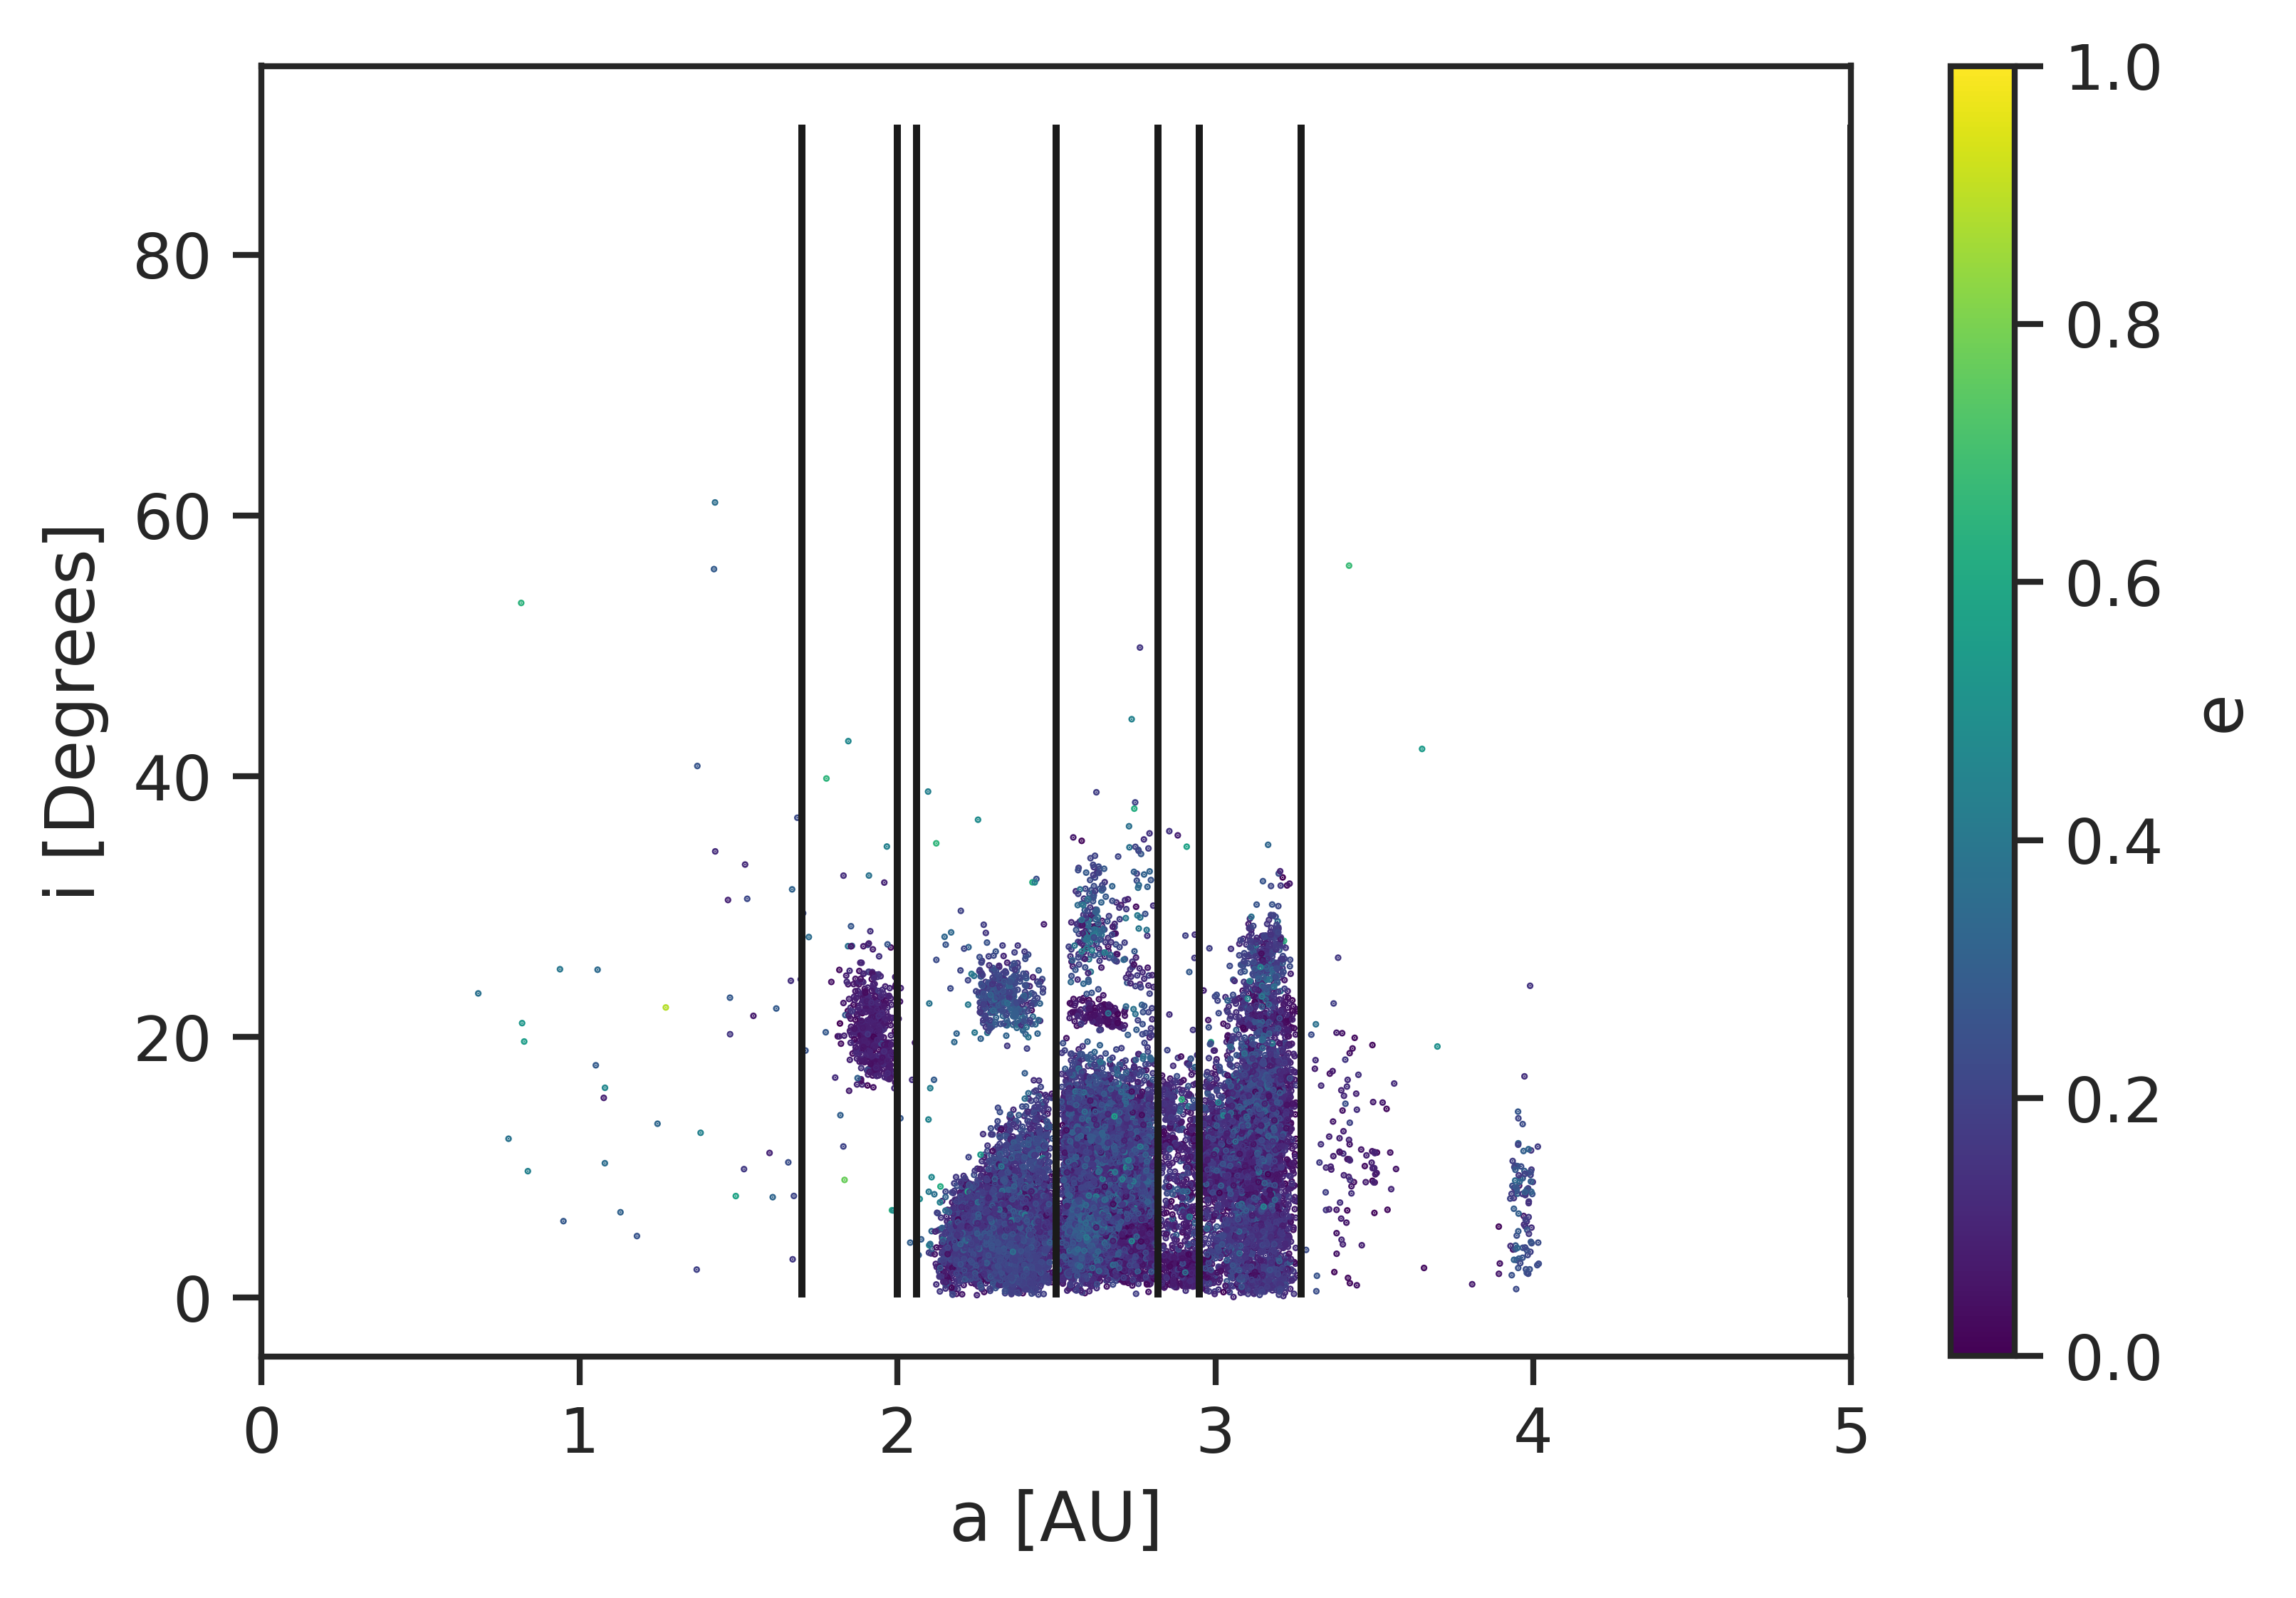

In [8]:
fig, ax = thor.plotOrbitsFindable(allObjects_survey, orbits)
ax.set_xlim(0, 5)
ax.vlines([1.7, 2.00, 2.06, 2.5, 2.82, 2.95, 3.27, 5.0], 0, 90)

In [11]:
simulated_ephemeris["exp_mjd"] = simulated_ephemeris["mjd_utc"]

In [12]:
objs = observations[observations["nid"].isin([610, 611, 612, 613, 614, 615, 616, 617])]["designation"].unique()
#objs_findable = allObjects_survey[(allObjects_survey["findable"] == 1) & (allObjects_survey["designation"].isin(objs))]["designation"].values
objs_findable = allObjects_survey[(allObjects_survey["findable"] == 1)]["designation"].values

In [13]:
size = 15
ras = np.arange(0, 360 + size, size)
decs = np.arange(-90, 90 + size, size)

In [ ]:
average_orbits_list = []

for ra_i, ra_f in zip(ras[:-1], ras[1:]):
    for dec_i, dec_f in zip(decs[:-1], decs[1:]):
        # See if  there are any observations in the patch
        observations_in_patch = observations[#(observations["designation"].isin(objs_findable))
                                             (observations[columnMapping["RA_deg"]] >= ra_i) 
                                             & (observations[columnMapping["RA_deg"]] < ra_f)
                                             & (observations[columnMapping["Dec_deg"]] < dec_f)
                                             & (observations[columnMapping["Dec_deg"]] >= dec_i)]
        if len(observations_in_patch) > 0:
            # Find time of first set of observations in patch (need to propagate orbit to that time)
            exp_mjd = observations_in_patch["exp_mjd"].min()
            average_orbits_patch = thor.findAverageOrbits(simulated_ephemeris[(simulated_ephemeris["RA_deg"] >= ra_i) 
                                                                                  & (simulated_ephemeris["RA_deg"] < ra_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] < dec_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] >= dec_i)],
                                                          #orbits[orbits["designation"].isin(objs_findable)], 
                                                          orbits,
                                                          elementType="keplerian", 
                                                          dValues=[1.7, 2.0, 2.3, 2.6, 2.9, 3.2, 3.5, 10],
                                                          verbose=False)
                                                          #columnMapping=columnMapping)
            average_orbits_patch["exp_mjd_start"] = [exp_mjd for i in range(0, len(average_orbits_patch))]
            average_orbits_list.append(average_orbits_patch)
                                        
average_orbits = pd.concat(average_orbits_list)

average_orbits.sort_values(by=["r_au"], inplace=True)
average_orbits["orbit_id"] = np.arange(1, len(average_orbits) + 1)
average_orbits.reset_index(inplace=True, drop=True)

orbits["i_rad"] = np.radians(orbits["i_deg"])
orbits["ascNode_rad"] = np.radians(orbits["ascNode_deg"])
orbits["argPeri_rad"] = np.radians(orbits["argPeri_deg"])
orbits["meanAnom_rad"] = np.radians(orbits["meanAnom_deg"])

average_orbits = average_orbits.drop(index=average_orbits[average_orbits["designation"].isna()].index)

In [ ]:
average_orbits_list = []

for ra_i, ra_f in zip(ras[:-1], ras[1:]):
    for dec_i, dec_f in zip(decs[:-1], decs[1:]):
        # See if  there are any observations in the patch
        observations_in_patch = observations[#(observations["designation"].isin(objs_findable))
                                             (observations[columnMapping["RA_deg"]] >= ra_i) 
                                             & (observations[columnMapping["RA_deg"]] < ra_f)
                                             & (observations[columnMapping["Dec_deg"]] < dec_f)
                                             & (observations[columnMapping["Dec_deg"]] >= dec_i)]
        if len(observations_in_patch) > 0:
            # Find time of first set of observations in patch (need to propagate orbit to that time)
            exp_mjd = observations_in_patch["exp_mjd"].min()
            average_orbits_patch = thor.findAverageOrbits(simulated_ephemeris[(simulated_ephemeris["RA_deg"] >= ra_i) 
                                                                                  & (simulated_ephemeris["RA_deg"] < ra_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] < dec_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] >= dec_i)],
                                                          #orbits[orbits["designation"].isin(objs_findable)], 
                                                          orbits[orbits["ascNode_deg"] <= 180], 
                                                          elementType="keplerian", 
                                                          dValues=[1.7, 2.0, 2.3, 2.6, 2.9, 3.2, 3.5, 5],
                                                          verbose=False)
                                                          #columnMapping=columnMapping)
            average_orbits_patch["exp_mjd_start"] = [exp_mjd for i in range(0, len(average_orbits_patch))]
            average_orbits_list.append(average_orbits_patch)
            
            average_orbits_patch = thor.findAverageOrbits(simulated_ephemeris[(simulated_ephemeris["RA_deg"] >= ra_i) 
                                                                                  & (simulated_ephemeris["RA_deg"] < ra_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] < dec_f)
                                                                                  & (simulated_ephemeris["Dec_deg"] >= dec_i)],
                                                          #orbits[orbits["designation"].isin(objs_findable)], 
                                                          orbits[orbits["ascNode_deg"] > 180], 
                                                          elementType="keplerian", 
                                                          dValues=[1.7, 2.0, 2.3, 2.6, 2.9, 3.2, 3.5, 5],
                                                          verbose=False)
                                                          #columnMapping=columnMapping)
            average_orbits_patch["exp_mjd_start"] = [exp_mjd for i in range(0, len(average_orbits_patch))]
            average_orbits_list.append(average_orbits_patch)
                                        
average_orbits = pd.concat(average_orbits_list)

average_orbits.sort_values(by=["r_au"], inplace=True)
average_orbits["orbit_id"] = np.arange(1, len(average_orbits) + 1)
average_orbits.reset_index(inplace=True, drop=True)

orbits["i_rad"] = np.radians(orbits["i_deg"])
orbits["ascNode_rad"] = np.radians(orbits["ascNode_deg"])
orbits["argPeri_rad"] = np.radians(orbits["argPeri_deg"])
orbits["meanAnom_rad"] = np.radians(orbits["meanAnom_deg"])

average_orbits = average_orbits.drop(index=average_orbits[average_orbits["designation"].isna()].index)

In [ ]:
for orbit_id in average_orbits["orbit_id"].values:
    orbit = average_orbits[average_orbits["orbit_id"] == orbit_id]
    
    new_epoch = average_orbits[average_orbits["orbit_id"] == orbit_id]["exp_mjd_start"].values[0]
    
    orbit_from_cat = orbits[orbits["designation"] == orbit["designation"].values[0]]
    current_epoch = orbit_from_cat["epoch_TT_mjd"]
    
    eph = thor.propagateTestParticle(orbit_from_cat[["a_au", "e", "i_rad", "ascNode_rad", "argPeri_rad", "meanAnom_rad"]].values[0], current_epoch, [new_epoch], observatoryCode="I41", mjdScale="TT", elementType="keplerian")
    
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "r_au"] = eph["r_au"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "RA_deg"] = eph["RA_deg"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "Dec_deg"] = eph["Dec_deg"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "exp_mjd"] = eph["mjd"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dX/dt_au_p_day"] = eph["HEclObj_dX/dt_au_p_day"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dY/dt_au_p_day"] = eph["HEclObj_dY/dt_au_p_day"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dZ/dt_au_p_day"] = eph["HEclObj_dZ/dt_au_p_day"].values[0]

In [ ]:
average_orbits_in_observations = observations[observations["designation"].isin(average_orbits["designation"].values)].copy()
average_orbits_in_observations.drop_duplicates(subset=["designation"], keep="first", inplace=True)

In [ ]:
average_orbits

In [ ]:
average_orbits = average_orbits.rename(columns={"RA_deg": columnMapping["RA_deg"], "Dec_deg": columnMapping["Dec_deg"]})

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Input Observations for Findable Objects: {}".format(len(observations)))
ax.vlines(ras, -90, 90)
ax.hlines(decs, 0, 360)
#fig.savefig("../analysis/ztf/199orbits_input_observations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[observations["designation"].isin(objs_findable)][[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Input Observations for Findable Objects: {}".format(len(observations)))
#fig.savefig("../analysis/ztf/199orbits_input_observations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Input Observations: {}".format(len(observations)))
#fig.savefig("../analysis/ztf/199orbits_input_observations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[observations["obs_id"].isin(linked_detections)][[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Linked Observations: {}".format(len(observations[observations["obs_id"].isin(linked_detections)])))
#fig.savefig("../analysis/ztf/199orbits_linked_observations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[~observations["obs_id"].isin(linked_detections)][[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Unlinked Observations: {}".format(len(observations[~observations["obs_id"].isin(linked_detections)])))
#fig.savefig("../analysis/ztf/199orbits_unlinked_observations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[observations["designation"].isin(linked_objects)][[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Linked Object Observations (Assuming Attribution): {}".format(len(observations[observations["designation"].isin(linked_objects)])))
#fig.savefig("../analysis/ztf/199orbits_linked_objects.png")

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=600)
ax.scatter(*observations[observations["designation"].isin(missed_objects)][[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values.T,
           s=0.1,
           c="b")
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)
ax.set_aspect("equal")
ax.set_xlabel("RA [Degrees]", size=10)
ax.set_ylabel("Dec [Degrees]", size=10)
ax.set_title("Missed Object Observations [No Noise]: {}".format(len(observations[observations["designation"].isin(missed_objects)])))
#fig.savefig("../analysis/ztf/199orbits_missed_objects.png")

In [ ]:
! rm -rf ../analysis/ztf/run_12/

In [ ]:
observations = pd.merge(observations, simulated_ephemeris[["designation", "r_au"]], 
                        left_on="designation", 
                        right_on="designation", 
                        how="left",
                        suffixes=('', '_y'))

In [ ]:
average_orbits[average_orbits["orbit_id"].isin(np.random.choice(average_orbits["orbit_id"].values, 20, replace=False))]

In [ ]:
allObjects_survey, summary_survey, summary_orbits = thor.runTHOR(observations, 
                                                                average_orbits[average_orbits["orbit_id"].isin(np.random.choice(average_orbits["orbit_id"].values, 5, replace=False))],
                                                                knownOrbits=orbits,
                                                                runDir="/epyc/projects/thor/thor/analysis/ztf/run_14/", 
                                                                cellArea=500,
                                                                cellShape="circle",
                                                                threads=40,
                                                                vxBins=300,
                                                                vyBins=300,
                                                                eps=0.005,
                                                                minSamples=5,
                                                                unknownIDs=[-1],
                                                                columnMapping=columnMapping)

In [ ]:
projected_obs = pd.read_csv("../analysis/ztf/run_3/orbit_0001/projected_obs.txt", sep=" ", index_col=False)

In [ ]:
observations[observations["obs_id"].isin(projected_obs["obs_id"].values)]

In [ ]:
from thor import TestParticle

In [ ]:
o = average_orbits[average_orbits["orbit_id"] == 1]

In [ ]:
o

In [ ]:
x_e = projected_obs[['HEclObsy_X_au', 'HEclObsy_Y_au', 'HEclObsy_Z_au']].values[0]

In [ ]:
particle = TestParticle(o[["ra", "decl"]].values[0], 
                        o["r_au"].values[0],
                        o[["HEclObj_dX/dt_au_p_day",
                           "HEclObj_dY/dt_au_p_day",
                           "HEclObj_dZ/dt_au_p_day"]].values[0],
                           x_e, 
                           o["exp_mjd"].values[0])

In [ ]:
particle.prepare()

In [ ]:
from thor import Cell

In [ ]:
cell = Cell(o[["ra", "decl"]].values[0], o["exp_mjd"].values[0], projected_obs, shape="circle", area=500)

In [ ]:
cell.getObservations(columnMapping=columnMapping)

In [ ]:
cell.observations


In [ ]:
particle.apply(cell, columnMapping=columnMapping)

In [ ]:
verbose = True
from thor.vectors import *
from thor.coordinates import *
from thor.projections import *
self = particle

if verbose is True:
    print("Applying rotation matrices to observations...")
    print("Convering to ecliptic coordinates...")
coords_ec = equatorialToEclipticAngular(np.radians(cell.observations[[columnMapping["RA_deg"], columnMapping["Dec_deg"]]].values))

if verbose is True:
    print("Calculating object to observer unit vector...")
n_ae = calcNae(coords_ec)
x_e = cell.observations[[columnMapping["obs_x_au"], columnMapping["obs_y_au"], columnMapping["obs_z_au"]]].values

if verbose is True:
    print("Calculating object to observer distance assuming r = {} AU...".format(self.r))
delta = np.zeros(len(n_ae))
for i, (n_ae_i, x_e_i) in enumerate(zip(n_ae, x_e)):
    delta[i] = calcDelta(self.r, x_e_i, n_ae_i)

if verbose is True:
    print("Calculating object to observer position vector...")
x_ae = np.zeros([len(delta), 3])
for i, (delta_i, n_ae_i) in enumerate(zip(delta, n_ae)):
    x_ae[i] = calcXae(delta_i, n_ae_i)

if verbose is True:
    print("Calculating barycentic object position vector...")
x_a = np.zeros([len(x_ae), 3])
for i, (x_ae_i, x_e_i) in enumerate(zip(x_ae, x_e)):
    x_a[i] = calcXa(x_ae_i, x_e_i)

if verbose is True:
    print("Applying rotation matrix M to barycentric object position vector...")
coords_cart_rotated = np.array(self.M @ x_a.T).T

if verbose is True:
    print("Performing gnomonic projection...")
gnomonic = cartesianToGnomonic(coords_cart_rotated)

cell.observations["theta_x_deg"] = np.degrees(gnomonic[:, 0])
cell.observations["theta_y_deg"] = np.degrees(gnomonic[:, 1])

if verbose is True:
    print("Done.")
    print("") 

In [ ]:
x_e

In [ ]:
delta = np.zeros(len(n_ae))
for i, (n_ae_i, x_e_i) in enumerate(zip(n_ae, x_e)):
    print(n_ae_i, x_e_i)
    print(calcDelta(self.r, x_e_i, n_ae_i))
    delta[i] = calcDelta(self.r, x_e_i, n_ae_i)

In [ ]:
from numpy.linalg import norm

In [ ]:
-np.dot(n_ae_i, x_e_i) #+ np.sqrt(norm(np.dot(n_ae_i, x_e_i))** 2 + self.r**2 - norm(x_e_i)**2)

In [ ]:
n_ae_i

In [ ]:
n_ae

In [ ]:
observations[observations["designation"].isin(["f3563"])]

In [ ]:
summary_orbits = pd.read_csv("../analysis/ztf/run_3/summary_orbits.txt", sep=" ", index_col=False)
summary_orbits = summary_orbits.merge(average_orbits)

In [ ]:
summary_orbits

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(summary_orbits["r_au"].values, 
           summary_orbits["percent_completeness"].values, 
           s=1)
          #c=summary_orbits["r_au"].values)
#ax.scatter(summary_orbits["r_au"].values, summary_orbits["num_unique_known_objects_missed"].values, s=1)


In [ ]:
linked_detections = np.loadtxt("../analysis/ztf/run_3/linked_detections.txt", dtype=int)

In [ ]:
fig, ax = plt

In [ ]:
np.dot(n_ae_i, x_e_i)** 2

In [ ]:
norm(x_e_i)**2

In [ ]:
np.sqrt(norm(np.dot(n_ae_i, x_e_i)))

In [ ]:
np.dot(n_ae_i, x_e_i)

In [ ]:
cell.observations

In [ ]:
n_ae 

In [ ]:
allObjects_noise = pd.read_csv("../analysis/ztf/run_10/allObjects_survey.txt", index_col=False, sep=" ")
allObjects_no_noise = pd.read_csv("../analysis/ztf/run_7/allObjects_survey.txt", index_col=False, sep=" ")
summary_noise = pd.read_csv("../analysis/ztf/run_10/summary_survey.txt", index_col=False, sep=" ")
summary_no_noise = pd.read_csv("../analysis/ztf/run_7/summary_survey.txt", index_col=False, sep=" ")

In [ ]:
found_no_noise = allObjects_no_noise[allObjects_no_noise["found"] == 1]["designation"].unique()
found_noise = allObjects_noise[allObjects_noise["found"] == 1]["designation"].unique()

In [ ]:
len(found_no_noise)

In [ ]:
len(found_noise)

In [ ]:
set(found_no_noise).difference(set(found_noise))

In [ ]:
set(found_noise).difference(set(found_no_noise))

In [ ]:
set(found_noise).difference

In [ ]:
summary_no_noise

In [ ]:
summary_noise